# Etap I - EDA 

## Wczytanie danych

In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math


#PK: problem z wczytaniem danych - blad 403 forbidden przy normalnym wczytaniu
#PK: https://datascience.stackexchange.com/questions/49751/read-csv-file-directly-from-url-how-to-fix-a-403-forbidden-error

from io import StringIO
import requests

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
url = "https://datahub.io/machine-learning/sick/r/sick.csv"
s = requests.get(url, headers = headers).text
df = pd.read_csv(StringIO(s))

# Thyroid disease records supplied by the Garavan Institute and J. Ross Quinlan, New South Wales Institute, Syndney, Australia. 1987.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive/')

## Wstępna analiza zbioru - zapoznanie się z danymi

Zajmiemy się analizą zbioru sick, pochodzącego z OpenML100. Zbiór ten zawiera rekordy z badaniami pacjentów zebrane w roku 1987. Targetem w sick jest kolumna class, która określa czy dany pacjent ma chorobę tarczycy czy nie. Wszystkich kolumn jest 30 i wnoszą one informacje o danym pacjencie.

In [3]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

Mamy kolumny o zmiennych kategorycznych jak i ciągłych. Kolumny ciągłe oraz kolumna określająca płeć mają brakujące dane (missing values).


In [5]:
print(all(np.array(df.TSH_measured=="f") == np.array(df.TSH.isna())))
print(all(np.array(df.T3_measured=="f") == np.array(df.T3.isna())))
print(all(np.array(df.TT4_measured=="f") == np.array(df.TT4.isna())))
print(all(np.array(df.T4U_measured=="f") == np.array(df.T4U.isna())))
print(all(np.array(df.FTI_measured=="f") == np.array(df.FTI.isna())))
print(all(np.array(df.TBG_measured=="f") == np.array(df.TBG.isna())))

True
True
True
True
True
True


Kolumny o nawach kończących się "_measured" nie wnoszą dodatkowych informacji, bo "f" oznacza NA w odpowiadających im kolumnach.

In [6]:
np.unique(np.array(df.iloc[:,2:16]))

array(['f', 't'], dtype=object)

Wniosek (całkiem oczekiwany po ujrzeniu fragmentu zbioru) -  kolumny 2:15 maja tylko informacje true/false.
Na początek skonwertujmy je na wartości boolean. Przy tworzeniu modeli wykorzystamy zamianę na 0/1 albo wykorzystamy inne techniki encodingu.

Kolumn "_measured" na razie usuniemy, aby analiza była czytelniejsza, jednak mogą się one przydać przy późniejszej inżynierii cech.


In [7]:
data = pd.DataFrame(index = df.index, columns = df.columns[np.logical_not(df.columns.isin(["TSH_measured", "T3_measured", "TT4_measured", "T4U_measured", "FTI_measured", "TBG_measured"]))])
data.fillna(value = 0, inplace = True)

data.iloc[:,0:2] = df.iloc[:, 0:2]
data.iloc[:,2:16] = df.iloc[:, 2:16] == "t"
data.iloc[:,16:22] = df.loc[:,["TSH", "T3", "TT4", "T4U", "FTI", "TBG"]]
data.iloc[:, 22:24] = df.loc[:, ["referral_source", "Class"]]

data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,Class
0,41.0,F,False,False,False,False,False,False,False,False,...,False,False,1.30,2.5,125.0,1.14,109.0,NaN,SVHC,negative
1,23.0,F,False,False,False,False,False,False,False,False,...,False,False,4.10,2.0,102.0,NaN,NaN,NaN,other,negative
2,46.0,M,False,False,False,False,False,False,False,False,...,False,False,0.98,NaN,109.0,0.91,120.0,NaN,other,negative
3,70.0,F,True,False,False,False,False,False,False,False,...,False,False,0.16,1.9,175.0,NaN,NaN,NaN,other,negative
4,70.0,F,False,False,False,False,False,False,False,False,...,False,False,0.72,1.2,61.0,0.87,70.0,NaN,SVI,negative


In [8]:
from pandas.testing import assert_frame_equal
assert_frame_equal(data.iloc[:,[0, 1, 16, 17, 18, 19, 20, 21, 22, 23]], df.iloc[:, [0, 1, 17, 19, 21, 23, 25, 27, 28, 29]])
#Sprawdzone: data jest naszym przygotowanym zbiorem danym do dalszej analizy i obróbki

In [9]:
print(data.sex.value_counts())
data.groupby("sex").Class.value_counts(normalize = True)

F    2480
M    1142
Name: sex, dtype: int64


sex  Class   
F    negative    0.945161
     sick        0.054839
M    negative    0.922067
     sick        0.077933
Name: Class, dtype: float64

Więcej kobiet niż mężczyzn w zbiorze, może to wynikać z faktu iż w rzeczywistości to częściej kobiety chorują na tarczycę. Liczba osób chorych (stosunek wartości w targecie) jest dość niska, więc dane nie są zbalansowane. 

Sprawdźmy teraz klasy kolumn.

In [10]:
data.dtypes

age                          float64
sex                           object
on_thyroxine                    bool
query_on_thyroxine              bool
on_antithyroid_medication       bool
sick                            bool
pregnant                        bool
thyroid_surgery                 bool
I131_treatment                  bool
query_hypothyroid               bool
query_hyperthyroid              bool
lithium                         bool
goitre                          bool
tumor                           bool
hypopituitary                   bool
psych                           bool
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
TBG                          float64
referral_source               object
Class                         object
dtype: object

Po wprowadzeniu poprawek większość kolumn została zamieniona na wartości True/False (boolean), dodatkowo jest kilka zmiennych typu float oraz trzy zmienne kategoryczne.

In [11]:
print(data.sick.value_counts())
print(data.Class.value_counts())

False    3625
True      147
Name: sick, dtype: int64
negative    3541
sick         231
Name: Class, dtype: int64


Kolumny sick i Class wzkazują inne dane,gdyż ich wartości się nie zgadzają. Wiemy, że target - Class - oznacza chorobę tarczycy lub jej brak, więc możemy zakładać, że sick określa jakieś możliwe przeziębienie pacjenta podczas badań.

In [12]:
data["Class"]=df["Class"]=="sick"
data=data.rename(columns={"Class":"Thyroid_disease"})

Zmieniamy nazwę kolumny Class na bardziej oczywistą.

In [13]:
pd.unique(data.referral_source)
#ewentualnie można zamienić tę kolumnę na 0,1,2,3,4

array(['SVHC', 'other', 'SVI', 'STMW', 'SVHD'], dtype=object)

In [14]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,Thyroid_disease
0,41.0,F,False,False,False,False,False,False,False,False,...,False,False,1.30,2.5,125.0,1.14,109.0,NaN,SVHC,False
1,23.0,F,False,False,False,False,False,False,False,False,...,False,False,4.10,2.0,102.0,NaN,NaN,NaN,other,False
2,46.0,M,False,False,False,False,False,False,False,False,...,False,False,0.98,NaN,109.0,0.91,120.0,NaN,other,False
3,70.0,F,True,False,False,False,False,False,False,False,...,False,False,0.16,1.9,175.0,NaN,NaN,NaN,other,False
4,70.0,F,False,False,False,False,False,False,False,False,...,False,False,0.72,1.2,61.0,0.87,70.0,NaN,SVI,False


In [15]:
data.Thyroid_disease[data.tumor].value_counts()

False    94
True      2
Name: Thyroid_disease, dtype: int64

Ciekawostka - tylko dwie osoby mające guzy mają chorą tarczycę.

In [16]:
data["sex"]=data["sex"].replace(np.nan, "Missing", regex=True)
pd.unique(data.sex)

array(['F', 'M', 'Missing'], dtype=object)

Brakujące wartości w kolumnie sex zamieniamy na "Missing", jednak ważne jest aby o tym pamiętać przy imputacji.

Przyjrzyjmy się teraz licznościom pacjentów (powyżej było to w liczbach, więc wiemy, że kobiet będzie więcej, sprawdźmy jak to wygląda na wykresie) i ich wiekowi - w postaci wizualizacji.

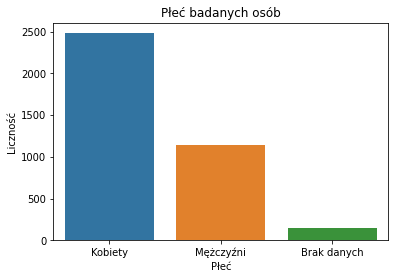

In [17]:
plot=sns.countplot(data.sex, dodge=False)
plot.set_title("Płeć badanych osób")
plot.set(xticklabels=["Kobiety", "Mężczyźni", "Brak danych"], xlabel="Płeć", ylabel="Liczność")
plot

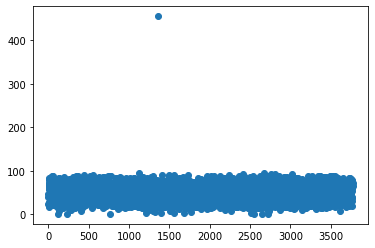

In [18]:
plt.plot(data.age, 'o')

Możemy zaobserwować dziwną wartość wieku powyżej 400. Nie jest to możliwe do osiągnięcia gdyż najdłużej żyjący człowiek miał nie całe 123 lata.

Sprawdźmy statystyki danych ciągłych, możliwe jest iż niektóre wartości także mają takie dziwne wartości jak przy kolumnie z wiekiem.

In [19]:
data.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000,0.0
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649,NaN
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698,NaN
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000,NaN
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000,NaN
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


Maksymalny wiek ma 455, przyjrzyjmy się wpisowi tego pacjenta, może inne jego dane także są nierealne.

In [20]:
data[data.age == 455]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,Thyroid_disease
1364,455.0,F,False,False,False,False,False,False,False,False,...,False,False,1.1,2.0,118.0,1.13,104.0,NaN,SVI,False


Na pierwszy rzut oka powyższe dane wyglądają one całkiem noramalnie. Przyjrzyjmy się jedynemu wpisowi gdzie wiek jest wartością NA.

In [21]:
data[data.age.isna()]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,Thyroid_disease
1985,NaN,F,True,False,False,False,False,False,True,False,...,False,False,0.6,1.5,120.0,0.82,146.0,NaN,other,False


Skoro są braki danych w wieku i wartości równe 455, czy to znaczy, że wiek uzupełniali sami pacjenci? Nie mamy wiedzy czy wpisany wiek jest pomyłką czy żartem. Dlatego najlepiej go będzie ustawić jako 45/46 (jeśli zakładamy to jako pomyłkę i brak przecinka) albo jako wartość NA i uzupełnić przy użyciu technik imputacji.


In [22]:
data2 = data[data["age"]<455]
data2.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,3770.000000,3401.000000,3001.000000,3539.000000,3383.000000,3385.000000,0.0
mean,51.628912,5.089258,2.013675,108.313309,0.995012,110.461064,NaN
std,18.982990,24.528465,0.827657,35.613396,0.195478,33.093651,NaN
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.000000,0.500000,1.600000,87.500000,0.880000,93.000000,NaN
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000,NaN
max,94.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


Bez wartości 455, maksymalny wiek jest realny do osiągnięcia, zobaczmy wykres tego

Uwaga: data2 nie zawiera wartości wieku powyżej 94 - używany do wykresów!


[Text(0.5, 0, 'Wiek')]

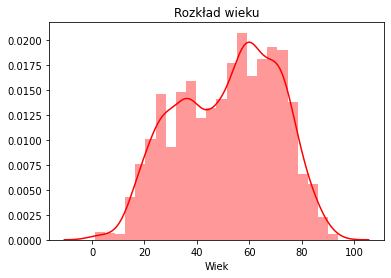

In [23]:
age_dens = sns.distplot(data2.age, hist = True, color='red')
age_dens.set_title('Rozkład wieku')
age_dens.set(xlabel="Wiek")

Rozkład wieku sugeruje, iż przebadani zostali pacjenci prawie w każdym wieku, większa część ma około 50-70 lat, jednak niewiele mniej jest pacjentów w przedziale 25-40.

In [24]:
female = data2[data2.sex=="F"]
female_age=female["age"]
male = data2[data2.sex=="M"]
male_age = male["age"]

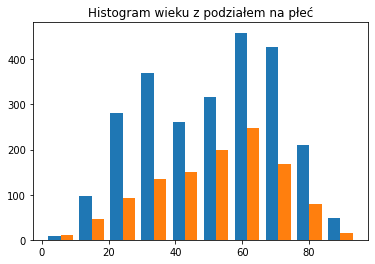

In [25]:
plt.hist([female.age, male.age])
plt.title("Histogram wieku z podziałem na płeć")
plt.show()
#PP: Jak chcemy użyć tego wykresu w raporcie to trzeba coś zrobić osią, aby była czytelniejsza

Skoro pojawiła się dziwna wartość wieku to warto spojrzeć raz jeszcze na zbiór i sprawdzić czy w innych kolumnach nie ma takich zakłamań.


In [26]:
data.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000,0.0
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649,NaN
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698,NaN
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000,NaN
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000,NaN
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


Sprawdzanie wartości w kolumnach continous - trochę biologii:

- TSH (tyreotropiny), wedle internetu norma wynosi od 0,32 do 4 albo 5 mIU/I (nie wliczając dzieci i kobiet w ciąży, u nich są inne), jednak możliwe są niskie jak i wysokie wartości, wedle internetu był mężczyzna co miał TSH około 400, więc ten hormon jest w normie

- T3 (trijodotyronina) - wyrózniamy dwie: całkowitą i wolną. T3 całkowita (TT3) ma normę 1,3–3,1 nmol/l, a T3 wolna (FT3) ma normę 4,0–7,8 pmol/l, zakładamy, że w zbiorze może chodzić o wolne T3, bo przy całkowitym T4 jest podpisane dokładnie tym skrótem co dokładnie to oznacza

- TT4 (tyroksyna) czyli T4 całkowita, norma 58–154 nmol/l

**!!!!!! TSH pobudza tarczycę do produkcji T4 i T3, warto sprawdzić korelacje !!!!!!!!!!**

- T4U - wykorzystanie tyroksyny przez organizm (eksploatacja, pobór)

- FTI - wolny testosteron, wiarygodny indeks do oceniania stanu tarczycy, FTI = Thyroxine (T4)/Thyroid Binding Capacity

- TBG - stężenie globuliny wiążącej tyroksynę, nie mamy danych, więc nie doszukujemy się więcej ilości informacji

## Braki danych - znalezienie ich (bez jakiegokolwiek zastąpienia ich)

Wiemy już, że hormony mogą mieć różne wartości, nawet abstrakcyjnie duże, więc załóżmy, że jest wszystko dobrze z danymi. W takim razie pora na przyjrzenie się brakom danych.


In [27]:
NA_ratio_columns = data.isnull().mean()
NA_ratio_columns.round(4) * 100

age                            0.03
sex                            0.00
on_thyroxine                   0.00
query_on_thyroxine             0.00
on_antithyroid_medication      0.00
sick                           0.00
pregnant                       0.00
thyroid_surgery                0.00
I131_treatment                 0.00
query_hypothyroid              0.00
query_hyperthyroid             0.00
lithium                        0.00
goitre                         0.00
tumor                          0.00
hypopituitary                  0.00
psych                          0.00
TSH                            9.78
T3                            20.39
TT4                            6.12
T4U                           10.26
FTI                           10.21
TBG                          100.00
referral_source                0.00
Thyroid_disease                0.00
dtype: float64

Tak jak powyżej mamy procenty brakujących danych w kolumnach, tak poniżej przedstawienie tego samego za pomocą liczby wartości brakujących.

In [28]:
data.isnull().sum()

age                             1
sex                             0
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH                           369
T3                            769
TT4                           231
T4U                           387
FTI                           385
TBG                          3772
referral_source                 0
Thyroid_disease                 0
dtype: int64

In [29]:
#wersja data bez braków danych przy age i bez kolumny TBG
data2 = data2[data2.columns[NA_ratio_columns < 100]]
#data2.isnull().mean()

In [30]:
data[data.sex == "Missing"].sex.count()

150

Podsumowanie:
- kolumna age ma dwie wartości dziwne - NaN i 455, co zrobić z nimi? Sugestia to zamian obu na NaN i sprawdzenie kilku metod imputacji
- kolumna sex ma 150 wartości NaN, tylko zostały zamienione na "Missing", uwaga przy pracy nad nimi!
- TBG ma same NaN, propozycja to usunąć wraz odpowiadającą kolumną "_measured", nic z niego nie wyciągniemy
- reszta wartości w porządku, NaN pojawiają się w wartościach continous, można uzupełnić (imputacja braków danych)
- dwie kolumny o typach object, reszta bool albo float

Komentarz: data (tzn. nasz zbiór danych sick) z usuniętymi brakami przy age i kolumną TBG to data2!!!

## Korelacje zmiennych i ich rozkłady

Hormony mogą mieć jakieś korelacje, więc spójrzmy na nie. Dodatkowo przyjrzymy się rozkładom, gdyż mogą okazać się cieakwe.

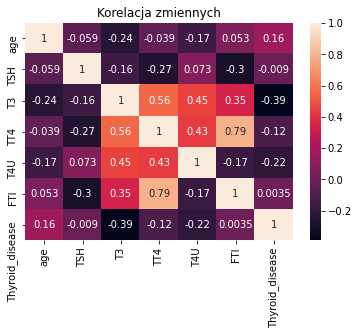

In [31]:
correlation = data.iloc[:, np.r_[0, 16:21, 23]].corr()
#Korelacja dla tylko zmiennych ciągłych + target (za dużo wszystkich zmiennych aby można było odczytać coś)
ax=sns.heatmap(correlation, 
            xticklabels=correlation.columns,
            yticklabels=correlation.columns, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)
ax.set_title('Korelacja zmiennych')
plt.show()

Przykładowe wnioski z wykresu korelacji:
- wysoka korelacja zachodzi między TT4 a FTI, ale wiemy już dlaczego - wskaźnik FTI wylicza się z TT4
- spadek T3 wpływa na niedoczynność tarczycy, w sumie to wszystkie hormony mają ujemną korelację, a wzrost wieku sprzyja chorobom tarczyc
- TT4 i T3 mają dodatnią korelację i to całkiem dużą (ciekawa zależność między nimi a TSH, wszystkie są w jakiejś zależności od siebie - szczegóły w internecie)
- T4U korelacja dodatnia, dość spora z powyższymi
- powyższe dwa punkty, to hormony wytwarzane przez tarczyce, ich zależności mogły być do przewidzenia

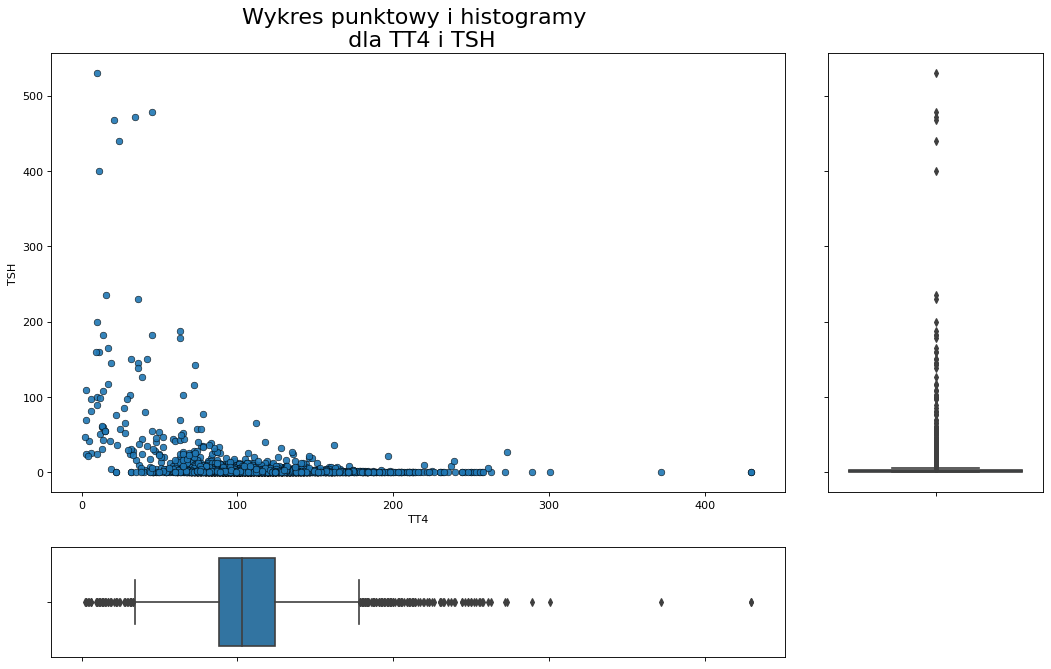

In [32]:
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])
ax_main.scatter('TT4', 'TSH', alpha=.9, data=data, cmap="Set1", edgecolors='black', linewidths=.5)
sns.boxplot(data.TSH, ax=ax_right, orient="v")
sns.boxplot(data.TT4, ax=ax_bottom, orient="h")
ax_bottom.set(xlabel='')
ax_right.set(ylabel='')
ax_main.set(title='Wykres punktowy i histogramy \n dla TT4 i TSH', xlabel='TT4', ylabel='TSH')
ax_main.title.set_fontsize(20)
for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(10)
plt.show()

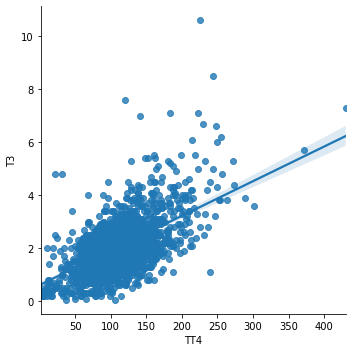

In [33]:
sns.lmplot(x='TT4', y='T3', data=data)

Powyżej widzimy przykładowe wykresy zależności zmiennych. Największa korelacja zachodzi dla T3 i TT4, ale znamy tego powody - tarczyca produkuje je w będąc w podobnym stanie.

Teraz kilka wykresów dla hormonów w zależności od płci pacjenta.

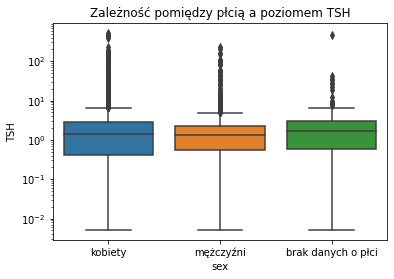

In [34]:
plot = sns.boxplot(data.sex, data.TSH)
plot.set_title('Zależność pomiędzy płcią a poziomem TSH')
plot.set(xticklabels=["kobiety","mężczyźni","brak danych o płci"], yscale="log")
plot

Skalowanie logarytmiczne dodane z powodu dużego zróżnicowania poziomu TSH (zazwyczaj jest on bardzo niski, ale zdarzają się wyniki ok.400).
Rozkład dosyć podobny niezależnie od płci. Wydaje się, że kobiety mają częściej wyższy poziom ale może to wynikać z faktu że więcej kobiet było badanych. 



In [35]:
def hormons_and_sex_boxplot(hormon, name):
  # hormon oznacza kolumnę w data z hormonem, który nas interesuje, a name to jego nazwa (string)
  plot = sns.boxplot(data.sex, hormon)
  plot.set_title('Zależność pomiędzy płcią a poziomem ' + name)
  plot.set(xticklabels=["kobiety","mężczyźni","brak danych o płci"])
  return plot

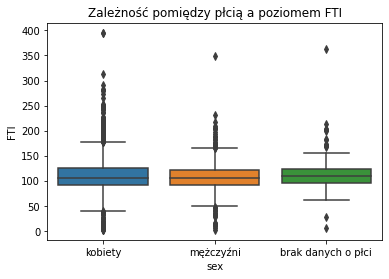

In [36]:
#Ciekawe jak to się ma wobec testosteronu:
hormons_and_sex_boxplot(data.FTI, "FTI")

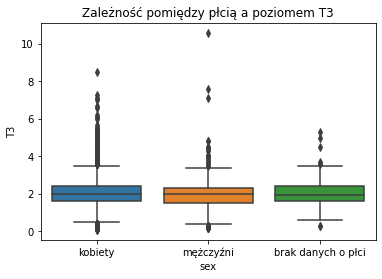

In [37]:
hormons_and_sex_boxplot(data.T3, "T3")

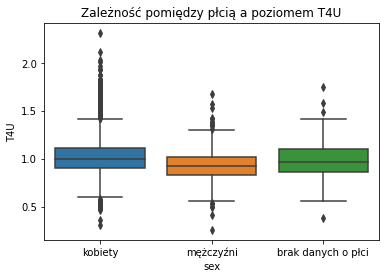

In [38]:
hormons_and_sex_boxplot(data.T4U, "T4U")

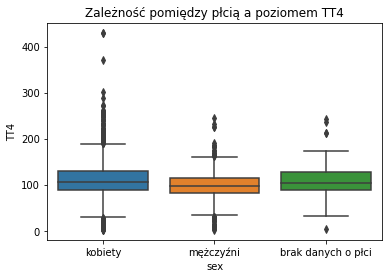

In [39]:
hormons_and_sex_boxplot(data.TT4, "TT4")

Wydaje się, że na poziom większości hormonów na płeć nie ma większego wpływu. A przynajmniej trudno coś z tego wywnioskować.

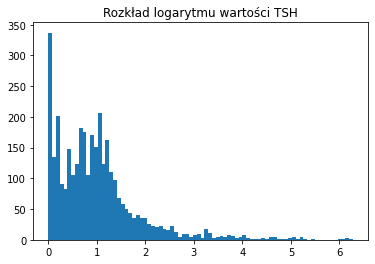

In [40]:
TSH_log = np.log1p(data.TSH)
TSH_log = TSH_log[~np.isnan(TSH_log)]
plt.hist(TSH_log, bins = 80)
plt.title("Rozkład logarytmu wartości TSH")
plt.show()

Rozkład TSH ma bardzo dużo wpisów o niskich wartościach. Dodatkowo długi ogon określa jak bardzo ludzie mogą mieć podwyższone TSH.

# Etap II - inżynieria cech i modelowanie




In [41]:
#instalacja pakietu do encodingu
#! pip install category_encoders
import category_encoders as ce

Jak wcześniej wspominaliśmy - zamienimy wartości True/False na 0/1. Dodatkowo skoro kolumna TBG jest całkowicie pusta to usuniemy ją.

In [42]:
data.iloc[:,2:16] = data.iloc[:,2:16].astype(int) #zamiana boolean na 0/1
data.drop('TBG', axis=1, inplace=True) #usunięcie TBG
data.head(7)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Thyroid_disease
0,41.0,F,0,0,0,0,0,0,0,0,...,0,0,0,1.30,2.5,125.0,1.14,109.0,SVHC,False
1,23.0,F,0,0,0,0,0,0,0,0,...,0,0,0,4.10,2.0,102.0,NaN,NaN,other,False
2,46.0,M,0,0,0,0,0,0,0,0,...,0,0,0,0.98,NaN,109.0,0.91,120.0,other,False
3,70.0,F,1,0,0,0,0,0,0,0,...,0,0,0,0.16,1.9,175.0,NaN,NaN,other,False
4,70.0,F,0,0,0,0,0,0,0,0,...,0,0,0,0.72,1.2,61.0,0.87,70.0,SVI,False
5,18.0,F,1,0,0,0,0,0,0,0,...,0,0,0,0.03,NaN,183.0,1.30,141.0,other,False
6,59.0,F,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,72.0,0.92,78.0,other,False


Przywróćmy kolumny "_measured", które mogą być jeszcze przydatne.

In [43]:
data.insert(16, "TSH_measured", df.TSH_measured == "t", True) 
data.insert(18, "T3_measured", df.T3_measured == "t", True) 
data.insert(20, "TT4_measured", df.TT4_measured == "t", True) 
data.insert(22, "T4U_measured", df.T4U_measured == "t", True) 
data.insert(24, "FTI_measured", df.FTI_measured == "t", True) 
data.loc[:, ["TSH_measured", "T3_measured", "TT4_measured", "T4U_measured", "FTI_measured"]] = data.loc[:, ["TSH_measured", "T3_measured", "TT4_measured", "T4U_measured", "FTI_measured"]].astype(int)
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Thyroid_disease
0,41.0,F,0,0,0,0,0,0,0,0,...,1,2.5,1,125.0,1,1.14,1,109.0,SVHC,False
1,23.0,F,0,0,0,0,0,0,0,0,...,1,2.0,1,102.0,0,NaN,0,NaN,other,False
2,46.0,M,0,0,0,0,0,0,0,0,...,0,NaN,1,109.0,1,0.91,1,120.0,other,False
3,70.0,F,1,0,0,0,0,0,0,0,...,1,1.9,1,175.0,0,NaN,0,NaN,other,False
4,70.0,F,0,0,0,0,0,0,0,0,...,1,1.2,1,61.0,1,0.87,1,70.0,SVI,False


## Zbiór treningowy i testowy

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3772 non-null   object 
 2   on_thyroxine               3772 non-null   int64  
 3   query_on_thyroxine         3772 non-null   int64  
 4   on_antithyroid_medication  3772 non-null   int64  
 5   sick                       3772 non-null   int64  
 6   pregnant                   3772 non-null   int64  
 7   thyroid_surgery            3772 non-null   int64  
 8   I131_treatment             3772 non-null   int64  
 9   query_hypothyroid          3772 non-null   int64  
 10  query_hyperthyroid         3772 non-null   int64  
 11  lithium                    3772 non-null   int64  
 12  goitre                     3772 non-null   int64  
 13  tumor                      3772 non-null   int64

I jak wyglądają braki danych w naszym zbiorze:



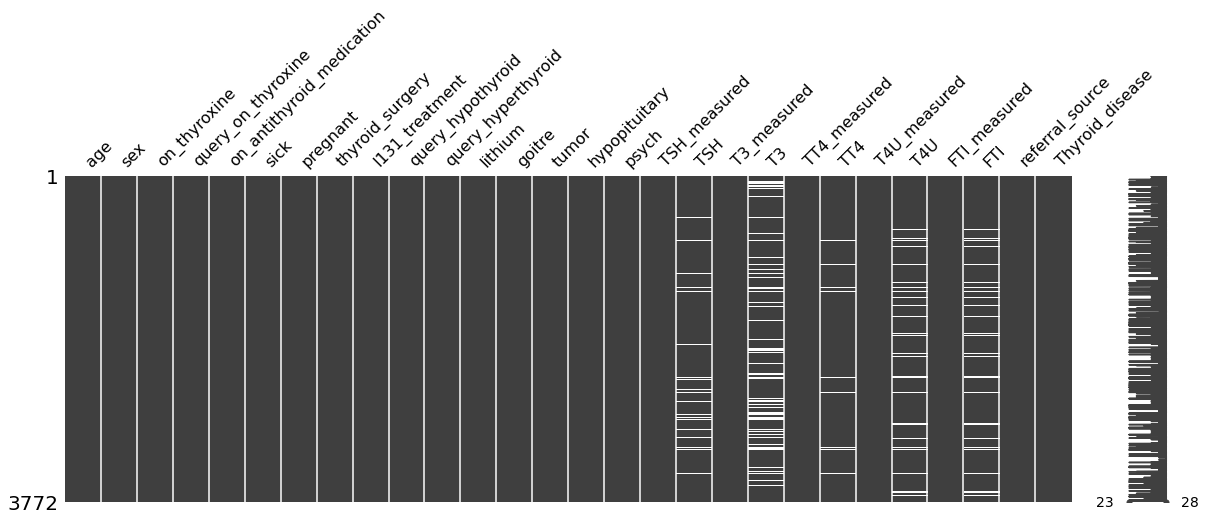

In [45]:
#!python3 -m pip install missingno
import missingno as mno
mno.matrix(data, figsize = (20, 6))

Zmienne kategoryczne do możliwego kodowania to: referral_source i sex. Dodatkowo zmienna opisująca (target do uczenia maszynowego) jest typu boolean - również zrzutujemy na 0/1.

Na początek zajmiemy się podziałem zmiennych na zbiór treningowy i testowy, a następnie przejdziemy do kodowania zmiennych.

In [46]:
# dzielimy zbiór na dwie części - z i bez kolumny targetu
y = np.array(data['Thyroid_disease'])
y = y.astype(int)
X = data.drop(['Thyroid_disease'],axis=1)

# podział na zbiór treningowy i testowy
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [47]:
data_train = data_train.reset_index(drop = True)
data_test = data_test.reset_index(drop = True)


Przyjrzyjmy się wymiarom powstałego podziału (poniżej). Mamy 27 kolumn (jak na razie, po encodingu może się coś zmienić) i podział na 3017 i 755 wierszy.

Sprawdźmy, do której z grup wpadł wpis o pacjencie z dziwnym wiekiem.

In [48]:
print(X.shape,data_train.shape,data_test.shape)

(3772, 27) (3017, 27) (755, 27)


In [49]:
data_train[data_train.age == 455]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source
1241,455.0,F,0,0,0,0,0,0,0,0,...,1.1,1,2.0,1,118.0,1,1.13,1,104.0,SVI


Okazuje się, że ten wpis znajduje się w zbiorze treningowym - trzeba o tym pamiętać przy zamianie wartości tego wieku.


Sprawdźmy jeszcze jak podzieliły się dane w targecie - nie są zbalansowane.

In [50]:
def np_counts(X):
  unique, counts = np.unique(X, return_counts=True)
  print(np.asarray((unique, counts)).T)

np_counts(target_train)
np_counts(target_test)

[[   0 2832]
 [   1  185]]
[[  0 709]
 [  1  46]]


Podział w obu przypadkach jest dość podobny, możemy założyć, że tak jest dobrze i przejść do kolejnych kroków.

## Encoding zmiennych kategorycznych

Przypomnijmy jak wygląda nasz zbiór na przykładzie data_train.

In [51]:
data_train.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source
0,20.0,F,0,0,1,0,0,0,0,0,...,0.15,1,2.5,1,93.0,1,1.00,1,93.0,other
1,28.0,F,0,0,0,0,0,0,0,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,other
2,66.0,F,0,0,0,0,0,0,0,0,...,0.10,1,1.8,1,108.0,1,0.71,1,151.0,SVI
3,77.0,F,0,0,0,0,0,0,0,0,...,2.50,1,1.7,1,101.0,1,0.85,1,119.0,SVI
4,34.0,F,0,0,0,0,0,0,0,0,...,NaN,1,5.3,1,181.0,1,1.04,1,174.0,other


Zajmiemy się kodowaniem referral_source i sex, wykorzystując różne rodzaje encodingu, aby móc potem je porównać.

Poniżej funkcja ułatwiająca późniejsze kodowanie zmiennych.

In [52]:
#funkcja wykorzystywana do kodowania zmiennych - posiada tylko kilka typów kodowania
def encoding(type_encoding : str, data_val : str, df_train, df_test, data_target = None):

    #type_encoding - skrót określający jaki typ kodowania wyboeramy
    #data_val - nazwa kolumny, którą zamierzamy kodować
    #data_target - wykorzystana przy m.in. TE do kodowania z targetem

    if(type_encoding == 'te'):
        en = ce.TargetEncoder(cols=[data_val], smoothing=0, return_df=True)
    if(type_encoding == 'ohe'):
        en = ce.OneHotEncoder(cols=[data_val], use_cat_names=True, return_df=True)
    if(type_encoding == 'me'):
        en = ce.MEstimateEncoder(cols=[data_val], return_df=True)
    if(type_encoding == 'oe'):
        en = ce.OrdinalEncoder(cols=[data_val], return_df=True)
        
    data_en_train = df_train.copy()
    data_en_test = df_test.copy()
    train_encoded = en.fit_transform(data_en_train, data_target)
    test_encoded = en.transform(data_en_test)
    
    return train_encoded, test_encoded

### Zmienna sex


#### Kodowanie na 0,1,NaN

Zmienną sex zakodujemy na 0,1 i wartości NaN, które potem uzupełnimy różnymi metodami.



In [53]:
# funkcja do mapowania zmiennej sex
def sex_encoding(data):
  df = data.copy()
  df.sex = df.sex.map({"M":0,"F":1,"Missing":np.nan})
  return df

In [54]:
data_train_sex_num = sex_encoding(data_train)
data_test_sex_num = sex_encoding(data_test)
data_train_sex_num.sex

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3012    1.0
3013    1.0
3014    1.0
3015    0.0
3016    1.0
Name: sex, Length: 3017, dtype: float64

Kolumna sex jest teraz określona jako float, przez występowanie wartości NaN nie możemy przekonwertować na int, choć da się na Int64 - na razie pozostawimy ją jako float.

## IMPUTACJA ZMIENNEJ SEX WARTOŚCIAMI LOSOWYMI

Chociaż imputacje będą dokonywane później, tę kolumnę uzupełnimy już teraz, bo wykorzystamy tylko jeden sposób uzupełnienia (nie skorzystamy z mody, gdyż kobiet i tak jest duża przewaga i podejrzewamy, że to byłaby niepoprawna metoda) i nie chcemy bezsensownie tworzyć większej ilości kodu (po zastosowaniu różnych metod kodowania będzie więcej zbiorów do edycji).
Jako, że w zbiorze mamy więcej kobiet, wartość brakująca z większym prawdopodobieństwem będzie kobietą - dlatego losujemy wartość 1 z większym prawdopodobieństwem.

In [55]:
import random
p_f = len(data[data.sex=="F"])/len(data.loc[data.sex.isin(["M", "F"])].sex)
p_m = 1-p_f
def sex_imputation(data):
    data.sex.fillna(np.random.choice([0.0, 1.0], p=[p_m, p_f]), inplace=True)
    data.sex = data.sex.astype('int64')
    return data

data_test_sex_num = sex_imputation(data_test_sex_num)
data_train_sex_num = sex_imputation(data_train_sex_num)

Zastąpiliśmy w losowy sposób te wartości, sprawdźmy, czy na pewno nie mamy braków danych w tej kolumnie:

In [56]:
data_train_sex_num.sex.isnull().any()

False

#### Kodowanie z wykorzystaniem funkcji do encodingu

W poprzednim przypadku zostawiliśmy NaN aby uzupełnić je np. losowo. Tutaj wprowadźmy kolejną kategorię płci - missing i zostawmy ją - zakodujemy to jedynie z wykorzystaniem Target Encoding (rozważany był także Ordinal Encoding).

In [57]:
#data_train_2 => data_train_sex_te
data_train_sex_te, data_test_sex_te = encoding('te', 'sex', data_train, data_test, target_train)
data_train_sex_te.sex.value_counts()

0.053080    1997
0.083885     906
0.026316     114
Name: sex, dtype: int64

In [58]:
#data_train_3 => data_train_sex_oe
data_train_sex_oe, data_test_sex_oe = encoding('oe', 'sex', data_train, data_test)
data_train_sex_oe.sex.value_counts()

1    1997
2     906
3     114
Name: sex, dtype: int64

Możliwe, że wybierzemy jedną z dwóch wersji, aby nie namnażać ilości testowanych zbiorów. Jednak na razie skupimy się najpierw na poprzednim kodowaniu, czyli tym z wartościami NaN.

### Zmienna referral_source

Zastosowano dwa rodzaje kodowania: Target Encoding i One Hot Encodinig. Mamy 5 wartości, więc ramka nie zwiększy się znacząco, dlatego pozwalamy sobie na OHE. Jest wiele podobnych encoderów do TE, dlatego nie zdecydowaliśmy się na nie - wybralismy tylko TE, a Ordinal Encoder jest dobry wtedy gdy mamy porządek i nie sprawdza się przy niektórych modelach uczenia maszynowego. Możliwe, że są inne dobre sposoby kodowania dla tego typu kolumny, jednak nie wszystkie są nam dobrze znane i przetestowane, dlatego skupimy się na tych wybranych dwóch.


#### Target encoding zmiennej refferal_source



In [59]:
#data_train_te => data_train_sex_num_rs_te
data_train_sex_num_rs_te, data_test_sex_num_rs_te = encoding('te', 'referral_source', data_train_sex_num, data_test_sex_num, target_train)
# przyjrzyjmy sie kodowaniu na przykładzie zbioru treningowego
data_train_sex_num_rs_te.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source
0,20.0,1,0,0,1,0,0,0,0,0,...,0.15,1,2.5,1,93.0,1,1.00,1,93.0,0.012907
1,28.0,1,0,0,0,0,0,0,0,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0.012907
2,66.0,1,0,0,0,0,0,0,0,0,...,0.10,1,1.8,1,108.0,1,0.71,1,151.0,0.186893
3,77.0,1,0,0,0,0,0,0,0,0,...,2.50,1,1.7,1,101.0,1,0.85,1,119.0,0.186893
4,34.0,1,0,0,0,0,0,0,0,0,...,NaN,1,5.3,1,181.0,1,1.04,1,174.0,0.012907


In [60]:
# a teraz testowego - po przyjrzeniu się możemy uznać, że kodowanie działa
data_test_sex_num_rs_te.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source
0,57.0,1,0,0,0,0,0,0,0,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0.012907
1,41.0,0,0,0,0,0,0,0,0,0,...,0.005,1,1.5,1,100.0,1,1.01,1,99.0,0.023649
2,66.0,1,0,0,0,0,0,1,0,0,...,1.700,1,1.4,1,89.0,1,0.87,1,103.0,0.186893
3,67.0,1,0,0,0,0,0,0,0,0,...,1.900,1,2.9,1,133.0,1,1.18,1,113.0,0.023649
4,62.0,0,0,0,0,0,0,0,0,0,...,1.100,1,2.3,1,130.0,1,1.24,1,105.0,0.012907


In [61]:
#data_train_te_2 => data_train_sex_te_rs_te
# dla target encodingu zmiennej sex do późniejszego wykorzystania
data_train_sex_te_rs_te, data_test_sex_te_rs_te = encoding('te', 'referral_source', data_train_sex_te, data_test_sex_te, target_train)

#### One Hot Encoding zmiennej refferal_source


In [62]:
#data_train_ohe => data_train_sex_num_rs_ohe
data_train_sex_num_rs_ohe, data_test_sex_num_rs_ohe = encoding('ohe', 'referral_source', data_train_sex_num, data_test_sex_num)
# przyjrzyjmy sie kodowaniu na przykładzie zbioru treningowego
data_train_sex_num_rs_ohe.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source_other,referral_source_SVI,referral_source_SVHC,referral_source_STMW,referral_source_SVHD
0,20.0,1,0,0,1,0,0,0,0,0,...,93.0,1,1.00,1,93.0,1,0,0,0,0
1,28.0,1,0,0,0,0,0,0,0,0,...,NaN,0,NaN,0,NaN,1,0,0,0,0
2,66.0,1,0,0,0,0,0,0,0,0,...,108.0,1,0.71,1,151.0,0,1,0,0,0
3,77.0,1,0,0,0,0,0,0,0,0,...,101.0,1,0.85,1,119.0,0,1,0,0,0
4,34.0,1,0,0,0,0,0,0,0,0,...,181.0,1,1.04,1,174.0,1,0,0,0,0


In [63]:
#data_train_ohe_2 => data_train_sex_te_rs_ohe
# dla Target Encodingu encodingu zmiennej sex

data_train_sex_te_rs_ohe, data_test_sex_te_rs_ohe = encoding('ohe', 'referral_source', data_train_sex_te, data_test_sex_te)

In [64]:
data_train_sex_te_rs_ohe.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source_other,referral_source_SVI,referral_source_SVHC,referral_source_STMW,referral_source_SVHD
0,20.0,0.05308,0,0,1,0,0,0,0,0,...,93.0,1,1.00,1,93.0,1,0,0,0,0
1,28.0,0.05308,0,0,0,0,0,0,0,0,...,NaN,0,NaN,0,NaN,1,0,0,0,0
2,66.0,0.05308,0,0,0,0,0,0,0,0,...,108.0,1,0.71,1,151.0,0,1,0,0,0
3,77.0,0.05308,0,0,0,0,0,0,0,0,...,101.0,1,0.85,1,119.0,0,1,0,0,0
4,34.0,0.05308,0,0,0,0,0,0,0,0,...,181.0,1,1.04,1,174.0,1,0,0,0,0


### Podsumowanie zmian i aktualnych nazw zbiorów

Zakodowaliśmy zmienną sex na trzy sposoby i kryja się one pod nazwami data_train_sex_i/data_test_sex_i, gdzie i oznacza odpowiednio:
+ kodowanie na 0,1,NaN - i = as_num
+ target encoder - i = te
+ ordinal encoder - i = oe

Następnie wykorzystaliśmy pierwszy i drugi sposób i zakodowaliśmy zmienną referral_source. Konwencja nazw po kodowaniu tej zmiennej to: data_train_sex_\{sposób kodowania sex\}\_rs_\{sposób kodowania rs}

## Imputacja brakujących wartości

In [65]:
# przyjrzenie się jakie są braki danych
def percent_of_NA(data):
  # zwraca procent brakujących wartości dla kolumn typu float
  NA_ratio_columns = data.select_dtypes('float').isnull().mean()
  return NA_ratio_columns.round(4) * 100

percent_of_NA(data_train_sex_num_rs_te)

age                 0.03
TSH                 9.81
T3                 20.95
TT4                 6.23
T4U                10.21
FTI                10.18
referral_source     0.00
dtype: float64

Zostały nam same kolumny z wartościami liczbowymi. Brakujące wartości pojawiają się przy kolumnach typu float. Teraz skupimy się na nich.


Na początek pamiętajmy o dziwnym wieku. Zastąpimy go na dwa sposoby:

In [66]:
# tworzymy dwie nowe ramki danych dla każdego kodowania - w których to dziwna wartość wieku zostaje zmieniona
def replace_age(data, value):
  data_r = data.copy()
  data_r.age = data.age.replace(455, value)
  return data_r

# przypisujemy wartości 455 wartość 45 - traktujemy wiek jako pomyłkę i naprawiamy ją
data_train_sex_num_rs_ohe_r45 = replace_age(data_train_sex_num_rs_ohe, 45)
data_test_sex_num_rs_ohe_r45 = replace_age(data_test_sex_num_rs_ohe, 45)
data_train_sex_num_rs_te_r45 = replace_age(data_train_sex_num_rs_te, 45)
data_test_sex_num_rs_te_r45 = replace_age(data_test_sex_num_rs_te, 45)
# przypisujemy wartości 455 wartość NaN - traktujemy to jako błąd/żart i wyliczymy wartość przy wykorzystaniu technik imputacji
data_train_sex_num_rs_ohe_rnan = replace_age(data_train_sex_num_rs_ohe, np.nan)
data_test_sex_num_rs_ohe_rnan = replace_age(data_test_sex_num_rs_ohe, np.nan)
data_train_sex_num_rs_te_rnan = replace_age(data_train_sex_num_rs_te, np.nan)
data_test_sex_num_rs_te_rnan = replace_age(data_test_sex_num_rs_te, np.nan)

Zastąpiliśmy wartością NaN albo 45 - problem pojawia się przy ilości używanych ramek danych. Ilość się podwoiła - **jednak zastąpiliśmy tylko dla kolumny sex zakodowanej na 0,1,NaN**.

### Mediana, średnia i moda

Na początek zastosujemy prostą metodę - usupełnimy braki medianą.

In [67]:
data_train_sex_num_rs_te_r45.select_dtypes('float').median()

age                 54.000000
TSH                  1.400000
T3                   2.000000
TT4                103.000000
T4U                  0.980000
FTI                107.000000
referral_source      0.012907
dtype: float64

In [68]:
from sklearn.impute import SimpleImputer

# tworzymy funkcję za pomocą której możemy imputować braki medianą/średnią
def easy_imputation(data_train, data_test, imp_type = 'median'):
    imp = SimpleImputer(missing_values=np.nan, strategy=imp_type)

    data_train_copy = data_train.copy()
    data_train_imp = pd.DataFrame(imp.fit_transform(data_train_copy.loc[:, ['age','TSH', 'T3', 'TT4', 'T4U', 'FTI']]), columns=['age','TSH', 'T3', 'TT4', 'T4U', 'FTI'])
    data_train_copy.age = data_train_imp.age.values
    data_train_copy.TSH = data_train_imp.TSH.values
    data_train_copy.T3 = data_train_imp.T3.values
    data_train_copy.TT4 = data_train_imp.TT4.values
    data_train_copy.T4U = data_train_imp.T4U.values
    data_train_copy.FTI = data_train_imp.FTI.values

    data_test_copy = data_test.copy()
    data_test_imp = pd.DataFrame(imp.transform(data_test_copy.loc[:, ['age','TSH', 'T3', 'TT4', 'T4U', 'FTI']]), columns=['age','TSH', 'T3', 'TT4', 'T4U', 'FTI'])
    data_test_copy.age = data_test_imp.age.values
    data_test_copy.TSH = data_test_imp.TSH.values
    data_test_copy.T3 = data_test_imp.T3.values
    data_test_copy.TT4 = data_test_imp.TT4.values
    data_test_copy.T4U = data_test_imp.T4U.values
    data_test_copy.FTI = data_test_imp.FTI.values
    
    return data_train_copy, data_test_copy

In [69]:
# target encoding dla referral_source
data_train_sex_num_rs_te_r45_med, data_test_sex_num_rs_te_r45_med = easy_imputation(data_train_sex_num_rs_te_r45, data_test_sex_num_rs_te_r45)
data_train_sex_num_rs_te_rnan_med, data_test_sex_num_rs_te_rnan_med = easy_imputation(data_train_sex_num_rs_te_rnan, data_test_sex_num_rs_te_rnan)
# one-hot encoding dla referral_source
data_train_sex_num_rs_ohe_r45_med, data_test_sex_num_rs_ohe_r45_med = easy_imputation(data_train_sex_num_rs_ohe_r45, data_test_sex_num_rs_ohe_r45)
data_train_sex_num_rs_ohe_rnan_med, data_test_sex_num_rs_ohe_rnan_med = easy_imputation(data_train_sex_num_rs_ohe_rnan, data_test_sex_num_rs_ohe_rnan)

In [70]:
# sprawdźmy na przykładowej ramce danych czy na pewno usunęlismy braki danych
percent_of_NA(data_train_sex_num_rs_te_r45_med)

age                0.0
TSH                0.0
T3                 0.0
TT4                0.0
T4U                0.0
FTI                0.0
referral_source    0.0
dtype: float64

Powyższe zbiory (mamy ich aż/tylko 8) zostały uzupełnione medianą. Teraz wykorzystamy średnią.

In [71]:
data_train_sex_num_rs_te_r45.select_dtypes('float').mean()

age                 51.731764
TSH                  5.340764
T3                   2.008486
TT4                108.161188
T4U                  0.995173
FTI                110.268155
referral_source      0.061319
dtype: float64

(Dla powyższego outputu gdzie mamy wybraną jedną ramkę) Większość hormonów się mieści w normie - poza TSH, który przekracza normę o 0.34 - 1.34 (w zależności o wybranej definicji).

In [72]:
# target encoding dla referral_source
data_train_sex_num_rs_te_r45_mean, data_test_sex_num_rs_te_r45_mean = easy_imputation(data_train_sex_num_rs_te_r45, data_test_sex_num_rs_te_r45, 'mean')
data_train_sex_num_rs_te_rnan_mean, data_test_sex_num_rs_te_rnan_mean = easy_imputation(data_train_sex_num_rs_te_rnan, data_test_sex_num_rs_te_rnan, 'mean')
# one-hot encoding dla referral_source
data_train_sex_num_rs_ohe_r45_mean, data_test_sex_num_rs_ohe_r45_mean = easy_imputation(data_train_sex_num_rs_ohe_r45, data_test_sex_num_rs_ohe_r45, 'mean')
data_train_sex_num_rs_ohe_rnan_mean, data_test_sex_num_rs_ohe_rnan_mean = easy_imputation(data_train_sex_num_rs_ohe_rnan, data_test_sex_num_rs_ohe_rnan, 'mean')

In [73]:
# sprawdźmy na przykładowej ramce danych czy na pewno usunęlismy braki danych
percent_of_NA(data_train_sex_num_rs_te_r45_mean)

age                0.0
TSH                0.0
T3                 0.0
TT4                0.0
T4U                0.0
FTI                0.0
referral_source    0.0
dtype: float64

Uzupełnijmy jeszcze modą nasze zbiory.

In [74]:
# target encoding dla referral_source
data_train_sex_num_rs_te_r45_mode, data_test_sex_num_rs_te_r45_mode = easy_imputation(data_train_sex_num_rs_te_r45, data_test_sex_num_rs_te_r45, 'most_frequent')
data_train_sex_num_rs_te_rnan_mode, data_test_sex_num_rs_te_rnan_mode = easy_imputation(data_train_sex_num_rs_te_rnan, data_test_sex_num_rs_te_rnan, 'most_frequent')
# one-hot encoding dla referral_source
data_train_sex_num_rs_ohe_r45_mode, data_test_sex_num_rs_ohe_r45_mode = easy_imputation(data_train_sex_num_rs_ohe_r45, data_test_sex_num_rs_ohe_r45, 'most_frequent')
data_train_sex_num_rs_ohe_rnan_mode, data_test_sex_num_rs_ohe_rnan_mode = easy_imputation(data_train_sex_num_rs_ohe_rnan, data_test_sex_num_rs_ohe_rnan, 'most_frequent')

In [75]:
# sprawdźmy na przykładowej ramce danych czy na pewno usunęlismy braki danych
percent_of_NA(data_train_sex_num_rs_te_r45_mode)

age                0.0
TSH                0.0
T3                 0.0
TT4                0.0
T4U                0.0
FTI                0.0
referral_source    0.0
dtype: float64

Podsumujmy ten akapit - mamy teraz zbiory, gdzie wartości ciągłe uzupełnione są medianą, średnią i modą, płeć jest uzupełniona losowo, dla źródeł o pacjentach mamy TE lub OHE, a wiek równy 455 został uzupełniony jako 45 albo imputacją. Nie uwzględnialismy metody polegającej na usuwaniu wierszy z brakami danych - stracilibyśmy zbyt dużo wierszy. 

### KNN imputer




Wypełnimy braki danych przy pomocy algorytmu k najbliższych sąsiadów 

In [76]:
from sklearn.impute import KNNImputer
def knn_imputation(data_train, data_test, k=61):
    imp = KNNImputer(n_neighbors=k, weights="uniform")  #n_neighbours ~ pierwiastek z liczby wierszy

    data_train_copy = data_train.copy()
    data_train_imp = pd.DataFrame(imp.fit_transform(data_train_copy.loc[:, ['age','TSH', 'T3', 'TT4', 'T4U', 'FTI']]), columns=['age','TSH', 'T3', 'TT4', 'T4U', 'FTI'])
    data_train_copy.age = data_train_imp.age.values
    data_train_copy.TSH = data_train_imp.TSH.values
    data_train_copy.T3 = data_train_imp.T3.values
    data_train_copy.TT4 = data_train_imp.TT4.values
    data_train_copy.T4U = data_train_imp.T4U.values
    data_train_copy.FTI = data_train_imp.FTI.values

    data_test_copy = data_test.copy()
    data_test_imp = pd.DataFrame(imp.transform(data_test_copy.loc[:, ['age','TSH', 'T3', 'TT4', 'T4U', 'FTI']]), columns=['age','TSH', 'T3', 'TT4', 'T4U', 'FTI'])
    data_test_copy.age = data_test_imp.age.values
    data_test_copy.TSH = data_test_imp.TSH.values
    data_test_copy.T3 = data_test_imp.T3.values
    data_test_copy.TT4 = data_test_imp.TT4.values
    data_test_copy.T4U = data_test_imp.T4U.values
    data_test_copy.FTI = data_test_imp.FTI.values
    
    return data_train_copy, data_test_copy

In [77]:
# target encoding dla referral_source
data_train_sex_num_rs_te_r45_knn, data_test_sex_num_rs_te_r45_knn = knn_imputation(data_train_sex_num_rs_te_r45, data_test_sex_num_rs_te_r45)
data_train_sex_num_rs_te_rnan_knn, data_test_sex_num_rs_te_rnan_knn = knn_imputation(data_train_sex_num_rs_te_rnan, data_test_sex_num_rs_te_rnan)
# one-hot encoding dla referral_source
data_train_sex_num_rs_ohe_r45_knn, data_test_sex_num_rs_ohe_r45_knn = knn_imputation(data_train_sex_num_rs_ohe_r45, data_test_sex_num_rs_ohe_r45)
data_train_sex_num_rs_ohe_rnan_knn, data_test_sex_num_rs_ohe_rnan_knn = knn_imputation(data_train_sex_num_rs_ohe_rnan, data_test_sex_num_rs_ohe_rnan)

In [78]:
# sprawdźmy na przykładowej ramce danych czy na pewno usunęlismy braki danych
percent_of_NA(data_train_sex_num_rs_te_r45_knn)

age                0.0
TSH                0.0
T3                 0.0
TT4                0.0
T4U                0.0
FTI                0.0
referral_source    0.0
dtype: float64

### ITERATIVE IMPUTATION

W podstawowej wersji ten sposób imputacji zwraca ujemne wartości dla poziomu hormonów. Z tego powodu, ustawiony został parametr min_value = 0.

In [79]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
def it_imputation(data_train, data_test, max=10):
   imp = IterativeImputer(max_iter=max, random_state = 70, min_value = 0)

   data_train_copy = data_train.copy()
   data_train_imp = pd.DataFrame(imp.fit_transform(data_train_copy.loc[:, ['age','TSH', 'T3', 'TT4', 'T4U', 'FTI']]), columns=['age','TSH', 'T3', 'TT4', 'T4U', 'FTI'])
   data_train_copy.age = data_train_imp.age.values
   data_train_copy.TSH = data_train_imp.TSH.values
   data_train_copy.T3 = data_train_imp.T3.values
   data_train_copy.TT4 = data_train_imp.TT4.values
   data_train_copy.T4U = data_train_imp.T4U.values
   data_train_copy.FTI = data_train_imp.FTI.values

   data_test_copy = data_test.copy()
   data_test_imp = pd.DataFrame(imp.transform(data_test_copy.loc[:, ['age','TSH', 'T3', 'TT4', 'T4U', 'FTI']]), columns=['age','TSH', 'T3', 'TT4', 'T4U', 'FTI'])
   data_test_copy.age = data_test_imp.age.values
   data_test_copy.TSH = data_test_imp.TSH.values
   data_test_copy.T3 = data_test_imp.T3.values
   data_test_copy.TT4 = data_test_imp.TT4.values
   data_test_copy.T4U = data_test_imp.T4U.values
   data_test_copy.FTI = data_test_imp.FTI.values
   
   return data_train_copy, data_test_copy

In [80]:
# target encoding dla referral_source
data_train_sex_num_rs_te_r45_iterimp, data_test_sex_num_rs_te_r45_iterimp = it_imputation(data_train_sex_num_rs_te_r45, data_test_sex_num_rs_te_r45)
data_train_sex_num_rs_te_rnan_iterimp, data_test_sex_num_rs_te_rnan_iterimp = it_imputation(data_train_sex_num_rs_te_rnan, data_test_sex_num_rs_te_rnan)
# one-hot encoding dla referral_source
data_train_sex_num_rs_ohe_r45_iterimp, data_test_sex_num_rs_ohe_r45_iterimp = it_imputation(data_train_sex_num_rs_ohe_r45, data_test_sex_num_rs_ohe_r45)
data_train_sex_num_rs_ohe_rnan_iterimp, data_test_sex_num_rs_ohe_rnan_iterimp = it_imputation(data_train_sex_num_rs_ohe_rnan, data_test_sex_num_rs_ohe_rnan)

/home/pawel/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/pawel/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/pawel/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/pawel/.local/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [81]:
# sprawdźmy na przykładowej ramce danych czy na pewno usunęlismy braki danych
percent_of_NA(data_train_sex_num_rs_te_r45_iterimp)

age                0.0
TSH                0.0
T3                 0.0
TT4                0.0
T4U                0.0
FTI                0.0
referral_source    0.0
dtype: float64

## XGBOOST 

One hot encoding

#### r45

In [82]:
from xgboost import XGBClassifier

model=XGBClassifier(random_state=1,
                    learning_rate=0.01, # Szybkość "uczenia" się
                    booster='gbtree',
                    nround = 100, # Ilość itereacji boosingowych
                    max_depth=4 # Maksymalna głębokość drzewa,
                    )
model.fit(data_train_sex_num_rs_ohe_r45_mean, target_train)
ohe_r45_mean_score = model.score(data_test_sex_num_rs_ohe_r45_mean, target_test)
model.fit(data_train_sex_num_rs_ohe_r45_med, target_train)
ohe_r45_med_score = model.score(data_test_sex_num_rs_ohe_r45_med, target_test)
model.fit(data_train_sex_num_rs_ohe_r45_mode, target_train)
ohe_r45_mode_score = model.score(data_test_sex_num_rs_ohe_r45_mode, target_test)
model.fit(data_train_sex_num_rs_ohe_r45_knn, target_train)
ohe_r45_knn_score = model.score(data_test_sex_num_rs_ohe_r45_knn, target_test)
model.fit(data_train_sex_num_rs_ohe_r45_iterimp, target_train)
ohe_r45_iterimp_score = model.score(data_test_sex_num_rs_ohe_r45_iterimp, target_test)
print("ohe_r45_mean_score", ohe_r45_mean_score)
print("ohe_r45_med_score", ohe_r45_med_score)
print("ohe_r45_mode_score", ohe_r45_mode_score)
print("ohe_r45_knn_score", ohe_r45_knn_score)
print("ohe_r45_iterimp_score", ohe_r45_iterimp_score)

ModuleNotFoundError: No module named 'xgboost'

#### rnan

In [83]:
model=XGBClassifier(random_state=1,
                    learning_rate=0.01, # Szybkość "uczenia" się
                    booster='gbtree',
                    nround = 100, # Ilość itereacji boosingowych
                    max_depth=4 # Maksymalna głębokość drzewa,
                    )
model.fit(data_train_sex_num_rs_ohe_rnan_mean, target_train)
ohe_rnan_mean_score = model.score(data_test_sex_num_rs_ohe_rnan_mean, target_test)
model.fit(data_train_sex_num_rs_ohe_rnan_med, target_train)
ohe_rnan_med_score = model.score(data_test_sex_num_rs_ohe_rnan_med, target_test)
model.fit(data_train_sex_num_rs_ohe_rnan_mode, target_train)
ohe_rnan_mode_score = model.score(data_test_sex_num_rs_ohe_rnan_mode, target_test)
model.fit(data_train_sex_num_rs_ohe_rnan_knn, target_train)
ohe_rnan_knn_score = model.score(data_test_sex_num_rs_ohe_rnan_knn, target_test)
model.fit(data_train_sex_num_rs_ohe_rnan_iterimp, target_train)
ohe_rnan_iterimp_score = model.score(data_test_sex_num_rs_ohe_rnan_iterimp, target_test)
print("ohe_rnan_mean_score", ohe_rnan_mean_score)
print("ohe_rnan_med_score", ohe_rnan_med_score)
print("ohe_rnan_mode_score", ohe_rnan_mode_score)
print("ohe_rnan_knn_score", ohe_rnan_knn_score)
print("ohe_rnan_iterimp_score", ohe_rnan_iterimp_score)

NameError: name 'XGBClassifier' is not defined

Target encoding


#### r45

In [84]:
model=XGBClassifier(random_state=1,
                    learning_rate=0.01, # Szybkość "uczenia" się
                    booster='gbtree',
                    nround = 100, # Ilość itereacji boosingowych
                    max_depth=4, # Maksymalna głębokość drzewa
                    )
model.fit(data_train_sex_num_rs_te_r45_mean, target_train)
te_r45_mean_score = model.score(data_test_sex_num_rs_te_r45_mean, target_test)
model.fit(data_train_sex_num_rs_te_r45_med, target_train)
te_r45_med_score = model.score(data_test_sex_num_rs_te_r45_med, target_test)
model.fit(data_train_sex_num_rs_te_r45_mode, target_train)
te_r45_mode_score = model.score(data_test_sex_num_rs_te_r45_mode, target_test)
model.fit(data_train_sex_num_rs_te_r45_knn, target_train)
te_r45_knn_score = model.score(data_test_sex_num_rs_te_r45_knn, target_test)
model.fit(data_train_sex_num_rs_te_r45_iterimp, target_train)
te_r45_iterimp_score = model.score(data_test_sex_num_rs_te_r45_iterimp, target_test)
print("te_r45_mean_score", te_r45_mean_score)
print("te_r45_med_score", te_r45_med_score)
print("te_r45_mode_score", te_r45_mode_score)
print("te_r45_knn_score", te_r45_knn_score)
print("te_r45_iterimp_score", te_r45_iterimp_score)

NameError: name 'XGBClassifier' is not defined

#### rnan

In [85]:
model=XGBClassifier(random_state=1,
                    learning_rate=0.01, # Szybkość "uczenia" się
                    booster='gbtree',
                    nround = 100, # Ilość itereacji boosingowych
                    max_depth=4, # Maksymalna głębokość drzewa
                    )
model.fit(data_train_sex_num_rs_te_rnan_mean, target_train)
te_rnan_mean_score = model.score(data_test_sex_num_rs_te_rnan_mean, target_test)
model.fit(data_train_sex_num_rs_te_rnan_med, target_train)
te_rnan_med_score = model.score(data_test_sex_num_rs_te_rnan_med, target_test)
model.fit(data_train_sex_num_rs_te_rnan_mode, target_train)
te_rnan_mode_score = model.score(data_test_sex_num_rs_te_rnan_mode, target_test)
model.fit(data_train_sex_num_rs_te_rnan_knn, target_train)
te_rnan_knn_score = model.score(data_test_sex_num_rs_te_rnan_knn, target_test)
model.fit(data_train_sex_num_rs_te_rnan_iterimp, target_train)
te_r45_iterimp_score = model.score(data_test_sex_num_rs_te_rnan_iterimp, target_test)
print("te_rnan_mean_score", te_rnan_mean_score)
print("te_rnan_med_score", te_rnan_med_score)
print("te_rnan_mode_score", te_rnan_mode_score)
print("te_rnan_knn_score", te_rnan_knn_score)
print("te_r45_iterimp_score", te_r45_iterimp_score)

NameError: name 'XGBClassifier' is not defined

Jak się okazuje, różne metody kodowania nie miały żadnego wpływu na jakość modelu XGBoost. W związku z tym, tylko dla wybranych sprawdzimy wpływ różnych parametrów na działanie funkcji.

In [86]:
learning_rates = [0.01, 0.05, 0.1, 0.15]
n_estimators = [50, 100, 300]
max_depths = [2, 4, 7, 10]
xgbScores = pd.DataFrame(columns=['learning_rate', 'n_estimators', 'max_depth', '1. Score', '2. Score'])
for lr in learning_rates:
  for est in n_estimators:
    for md in max_depths:
      model = XGBClassifier(random_state = 34,
                              learning_rate = lr,
                              n_estimators = est,
                              max_depth = md)
      model.fit(data_train_sex_num_rs_ohe_rnan_knn, target_train)
      ohe_rnan_knn_score = model.score(data_test_sex_num_rs_ohe_rnan_knn, target_test)
      model.fit(data_train_sex_num_rs_te_r45_iterimp, target_train)
      te_r45_iterimp_score = model.score(data_test_sex_num_rs_te_r45_iterimp, target_test)
      xgbScores = xgbScores.append({'learning_rate': lr, 'n_estimators': est, 'max_depth': md, '1. Score': ohe_rnan_knn_score, "2. Score": te_r45_iterimp_score}, ignore_index=True)

NameError: name 'XGBClassifier' is not defined

In [65]:
print(xgbScores[xgbScores["1. Score"] == max(xgbScores["1. Score"])])
print(xgbScores[xgbScores["2. Score"] == max(xgbScores["2. Score"])])
print(xgbScores[xgbScores["1. Score"] == min(xgbScores["1. Score"])])
print(xgbScores[xgbScores["2. Score"] == min(xgbScores["2. Score"])])

ValueError: max() arg is an empty sequence

Jak można zauważyć, przy wykorzystaniu drzew o większej głębokości, osiągane wyniki były wyższe niż przy drzewach dwupoziomowych. Podobnych wniosków nie można wyciągnąć na temat żadnej z innych zmiennych.

## Random Forest
Sprawdzimy skuteczność metody przy stosowaniu różnych metod kodowania zmiennych kategorycznych - wykorzystamy jedynie ramki danych, które zamieniły wiek '455' na nieokreśloną wartość.

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf = RandomForestClassifier(random_state = 354)

In [67]:
def RFtest(dataset, trainset, title, rf = rf, target_train = target_train, target_test = target_test):
  rf.fit(dataset, target_train)
  disp = metrics.plot_confusion_matrix(rf, trainset, target_test, normalize = 'all', values_format=".4g")
  disp.ax_.set_title(title)


NameError: name 'target_train' is not defined

Będziemy tworzyć macierze konfuzji - z racji charakterystyki zbioru, na którym pracujemy, potencjalnym podejściem może być chęć zminimalizowania liczbę przypadków False Negative (lewy dolny róg).

In [68]:
RFtest(data_train_sex_num_rs_te_rnan_med, data_test_sex_num_rs_te_rnan_med, "RS Target Encoding + Median Imputation")
RFtest(data_train_sex_num_rs_ohe_rnan_med, data_test_sex_num_rs_ohe_rnan_med, "RS One-Hot Encoding + Median Imputation")

NameError: name 'RFtest' is not defined

In [69]:
RFtest(data_train_sex_num_rs_te_rnan_mean, data_test_sex_num_rs_te_rnan_mean, "RS Target Encoding + Mean Imputation")
RFtest(data_train_sex_num_rs_ohe_rnan_mean, data_test_sex_num_rs_ohe_rnan_mean, "RS One-Hot Encoding + Mean Imputation")

NameError: name 'RFtest' is not defined

In [ ]:
RFtest(data_train_sex_num_rs_te_rnan_knn, data_test_sex_num_rs_te_rnan_knn, "RS Target Encoding + KNN Imputer")
RFtest(data_train_sex_num_rs_ohe_rnan_knn, data_test_sex_num_rs_ohe_rnan_knn, "RS One-Hot Encoding + KNN Imputer")

Obserwacja: w dotychczasowych przypadkach można odnieść wrażenie, że One-Hot Encoding skutkuje większym odsetkiem predykowanych 0.

In [70]:
RFtest(data_train_sex_num_rs_te_rnan_iterimp, data_test_sex_num_rs_te_rnan_iterimp, "RS Target Encoding + Iterative Imputer")
RFtest(data_train_sex_num_rs_ohe_rnan_iterimp, data_test_sex_num_rs_ohe_rnan_iterimp, "RS One-Hot Encoding + Iterative Imputer")

NameError: name 'RFtest' is not defined